In [40]:
import pandas as pd
import numpy as np
import prework as pwk
import string
import sys, os, io


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, Word2Vec
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
root = 'data/pilot4'

In [42]:
df_orig = pwk.load_data(root, 1, 'CHN', 'ENS')
df_orig.head(1)
df_1 = df_orig.drop('path', axis=1)
pd.set_option('display.max_colwidth', -1)
sum(df_1['label']=='CHN')*1./df_1.shape[0]

20


0.5

In [43]:
df_1.head(2)

,doc_id,author_code,essay_content,label,target
0,1,W_CHN_PTJ0_021_A2_0.txt,"﻿I agree that it is important for college students to have apart-time job. Nowadays, a large number of college students are having a part-time job. Some of them hold that part-time jobs can help them to adapt to the society well and give them many experiences. Take a friend of mine for example, when Lily was a college student, she went to supermarket as a promoter or went to be a family teacher every weekend. Then owing to her experiences, she quickly got a good job after graduating from university. in the other students' opinions, they think that they can buy goods they want their parents cannot afford. I know a student that he goes to a restaurant as a waiter at his part-time to earn enough money what a computer needs. Thus, it is important for college students to have a part-time job. However, our parents always don't agree us to get part-time jobs. They are afraid that our study and safety. In my opinion, having a good part-time job is good for students. We should pay attention to the advantages of part-time jobs and make the most of them. Meanwhile, we should learn to get knowledge from the part-time jobs and make them a helpful tool for our development.",CHN,1
1,2,W_CHN_PTJ0_022_A2_0.txt,"﻿In the last years, college students taking a part-time job become very popular in the big city. Many people believe that it is important for college students to have a part-time job. But I disagree with it. I have some reason to support my idea. Firstly, I hold that everyone should have the most important thing to be done in the different period. To be a student, study is the key word for us. If you cannot study well, you waste your time. Secondly, lots of students want to lessen their parents' financial burden through taking a part-time job. But it has a bad effect on their study. They do not know the most important thing their parents respect is that they can learn well and live a better life after they graduate. Therefore, pay much attention on your study now. The most important thing is not to have a part-time job right now, learn professional skills and practice yourself is the most serious thing in the university. If you want to earn more money, this will really help you later. So don't be influenced by others and try to keep on learning knowledge and you will succeed in the future.",CHN,1


In [97]:
X = df_1['essay_content']
y = df_1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [98]:
sum(y_train==1)*1./len(y_train)

0.5714285714285714

In [99]:
vectorizer = CountVectorizer(lowercase=True, max_features=10)
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [100]:
terms = np.array(vectorizer.get_feature_names())#[-5:]

In [101]:
clf = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)

In [102]:
accuracy_score(y_test, y_pred)

0.83333333333333337

In [103]:
y_test

1     1
19    0
16    0
15    0
13    0
8     1
Name: target, dtype: int64

In [104]:
y_pred

array([1, 1, 0, 0, 0, 1])

In [105]:
df_result = pd.DataFrame(zip(y_test.index+1, y_test.values, y_pred, ['yes' if i==True else 'no' for i in y_test.values!=y_pred]), columns=['docid', 'actual','predict', 'incorrect'])

In [106]:
df_result['actual'] = df_result['actual'].map({1: 'CHN', 0: 'ENS'})
df_result['predict'] = df_result['predict'].map({1: 'CHN', 0: 'ENS'})
df_result

,docid,actual,predict,incorrect
0,2,CHN,CHN,no
1,20,ENS,CHN,yes
2,17,ENS,ENS,no
3,16,ENS,ENS,no
4,14,ENS,ENS,no
5,9,CHN,CHN,no


In [107]:
terms[np.argsort(clf.coef_[0])]

array([u'and', u'to', u'that', u'of', u'have', u'the', u'for', u'job',
       u'part', u'time'], 
      dtype='<U4')

In [108]:
np.sort(clf.coef_[0])

array([-0.61788926, -0.38941854, -0.25351497, -0.23860107, -0.12682995,
        0.18298714,  0.21524368,  0.30504745,  0.46465243,  0.60475554])

In [109]:
term_coef = [t+'('+str(c)+')' for t,c in zip(terms, clf.coef_[0])]

### Take one essay from each class -- CHN and ENS

**Use the same vacabulary as the one used by Logistic Regression to generate term frequencies**

In [112]:
X_cn = df_1[1:2]['essay_content']
vec_cn = CountVectorizer(lowercase=True, vocabulary=terms)
X_cn_dtm = vec_cn.fit_transform(X_cn)

X_en = df_1[15:16]['essay_content']
vec_en = CountVectorizer(lowercase=True, vocabulary=terms)
X_en_dtm = vec_cn.fit_transform(X_en)

**Check the term frequency of the sample essay**

In [113]:
D_cn = X_cn_dtm.todense()
#np.sum(D_cn, axis=0)
print D_cn

D_en = X_en_dtm.todense()
#np.sum(D_en, axis=0)
print D_en

[[ 4  2  4  4  1  4  3 10  5  8]]
[[ 6  2  6  6  5  2  5  5  3 12]]


**Plot terms and term frequencies in both classes**

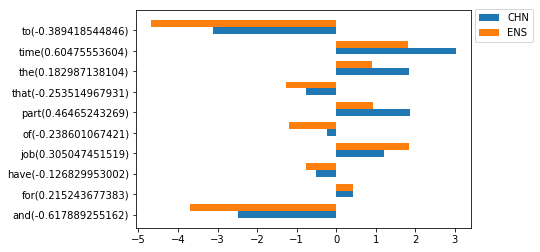

In [138]:
tf_cn = np.array(np.sum(D_cn, axis=0))[0]
tf_en = np.array(np.sum(D_en, axis=0))[0]
fig, ax = plt.subplots()

ax.barh(np.arange(0,30,3), tf_cn*clf.coef_[0], 1, label='CHN')
ax.barh(np.arange(0,30,3)+1, tf_en*clf.coef_[0], 1, label='ENS')
plt.yticks(np.arange(0,30,3), term_coef)
ax.legend(bbox_to_anchor=(1.2, 1.03))
fig.show()
#ax[0].barh(range(10), tf_cn)
#ax[1].barh(range(10), tf_en)

**As shown in the plot above, just using term frequency, the class of an essay is pretty clear**

**To prove the above conclusion, use the same Logistic Regression model to predict the probablity of the sample essays' classes**

In [115]:
print 'Essay id_2\'s Probablity of being CHN: ', clf.predict_proba(X_cn_dtm)[0][1]
print 'Essay id_16\'s Probablity of being ENS: ', clf.predict_proba(X_en_dtm)[0][0]

Essay id_2's Probablity of being CHN:  0.775028892123
Essay id_16's Probablity of being ENS:  0.996715579426


**Now let's analyze the incorrectly classified essay. This essay is written by a native speaker, but was classified as "written by Chinese author".**

In [118]:
X_wrong = df_1[19:20]['essay_content']
vec_wrong = CountVectorizer(lowercase=True, vocabulary=terms)
X_wrong_dtm = vec_cn.fit_transform(X_wrong)

In [119]:
D_wrong = X_wrong_dtm.todense()
#np.sum(D_en_wrong_dtm, axis=0)
print D_wrong

[[ 3  6  7  5  3  6  4  3  6 10]]


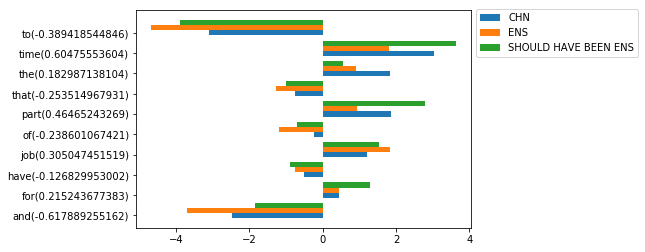

In [134]:
tf_cn = np.array(np.sum(D_cn, axis=0))[0]
tf_en = np.array(np.sum(D_en, axis=0))[0]
tf_wrong = np.array(np.sum(D_wrong, axis=0))[0]

fig, ax = plt.subplots()
ax.barh(np.arange(0,40,4), tf_cn*clf.coef_[0], 1, label='CHN')
ax.barh(np.arange(0,40,4)+1, tf_en*clf.coef_[0], 1, label='ENS')
ax.barh(np.arange(0,40,4)+2, tf_wrong*clf.coef_[0], 1, label='SHOULD HAVE BEEN ENS')

plt.yticks(np.arange(0,40,4), term_coef)
ax.legend(bbox_to_anchor=(1, 1.03))
fig.show()
#ax[0].barh(range(10), tf_cn)
#ax[1].barh(range(10), tf_en)

In [124]:
print 'Essay id_5\'s Probablity of being CHN: ', clf.predict_proba(X_wrong_dtm)[0][1]

Essay id_5's Probablity of being CHN:  0.799624017321


**Essay id_5 was classified as CHN because its term frequencies has greater similarities with general term frequency trends of Chinese essays**

## The final conclusion is that for this specific corpus, term frequency is not a reliable feature for classifiying the native language of a writing, despite the fact that sometimes the model will produce high accuracy score on BOTH training and testing sets

## Now increase the data volume

In [152]:
root = 'data/pilot'

df_orig2 = pwk.load_data(root, 1, 'CHN', 'ENS')
df_orig2.head(1)
df_2 = df_orig2.drop('path', axis=1)
pd.set_option('display.max_colwidth', -1)

print sum(df_2['label']=='CHN')*1./df_2.shape[0]

X2 = df_2['essay_content']
y2 = df_2['target']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7)

print sum(y2_train==1)*1./len(y2_train)

vectorizer2 = CountVectorizer(lowercase=True, max_features=200, ngram_range=(3,3))
X2_train_dtm = vectorizer2.fit_transform(X2_train)
X2_test_dtm = vectorizer2.transform(X2_test)

terms2 = np.array(vectorizer2.get_feature_names())#[-5:]

clf2 = LogisticRegression()
#clf.fit(X_train_dtm[120:140], y_train[120:140])
clf2.fit(X2_train_dtm, y2_train)
y2_pred = clf2.predict(X2_test_dtm)

print accuracy_score(y2_test, y2_pred)

209
0.521531100478
0.541095890411
0.920634920635


**Top 15 terms for classifying a document as Chinese**

In [153]:
terms2[np.argsort(clf2.coef_[0])[::-1][:15]]

array([u'doing part time', u'more and more', u'in my opinion',
       u'taking part time', u'part time job', u'for us to',
       u'the most important', u'nowadays more and', u'the part time',
       u'for college students', u'our college students', u'some part time',
       u'time job we', u'the college students', u'do part time'], 
      dtype='<U24')

**Top 15 terms for classifying a document as Native Speaker**

In [154]:
terms2[np.argsort(clf2.coef_[0])[:15]]

array([u'be able to', u'that it is', u'do not have', u'time job the',
       u'not have to', u'in order to', u'part time work', u'full time job',
       u'the real world', u'on their studies', u'as well as',
       u'to worry about', u'value of money', u'agree with this',
       u'second hand smoke'], 
      dtype='<U24')

In [37]:
#terms = array([u'and', u'for', u'have', u'is', u'it', u'part', u'that', u'the', u'time', u'to'], 

## Here using more documents from each class, and trigram terms, the top-15 "favorite terms" for Chinese writers and Native English writers are pretty different. As shown above, Chinese students tend to over use the term from the essay topic as their effort to keep the text content relevant, and they over use them due to limited vocabularies. In contrast, native speakers has a much wider range of frequent phrases to use.